**A picture is worth a thousand words - Visual Data Exploration**

Data is manifold, which makes it hard to discover its secrets and hidden relationships. Data Scientists can rack their brain on descriptive statistics or choose to explore the data using interactive visualisation tools. While both ways have benefits and dangerous pitfalls, the latter is definitely the more fun. This talk will help you discover your data visually by showing how you can quickly transform simple plots into powerful, interactive dashboards using Panel. Furthermore, it will provide you with a quick overview over Python’s most loved interactive plotting librarie 

# A Picture is worth a thousand words - Visual Data Exploration

*CorelCon 2021, 13.11.2021*

© Nico Kreiling, Data Scientist @ [Scieneers](https://www.scieneers.de/)


## Why visual data exploration?

* Quickly get an understanding for the data
* Dive in and Zoom out depending on your needs
* Be time efficient!

## "The human brain processes images 60,000 times faster than text." - [some shady website](https://www.t-sciences.com/news/humans-process-visual-data-better)

In [1]:
import pandas as pd
s = pd.Series([1,2,23,23,3,1,21,22,4,2,4,2,3,4,132,1,3,2])
s.describe()

count     18.000000
mean      14.055556
std       30.625772
min        1.000000
25%        2.000000
50%        3.000000
75%       16.750000
max      132.000000
dtype: float64

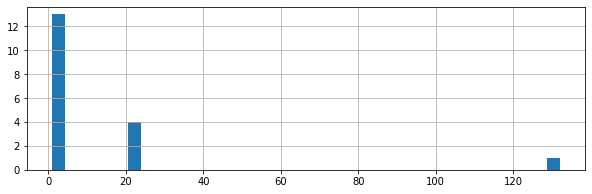

In [2]:
_ = s.hist(bins=40, figsize=(10,3))

## Descriptive statistics are hiding many information

In [3]:
df = pd.DataFrame({"a": s, "b": s.sort_index(ascending=False).to_list()})
df.describe()

,a,b
count,18.000000,18.000000
mean,14.055556,14.055556
std,30.625772,30.625772
min,1.000000,1.000000
25%,2.000000,2.000000
50%,3.000000,3.000000
75%,16.750000,16.750000
max,132.000000,132.000000


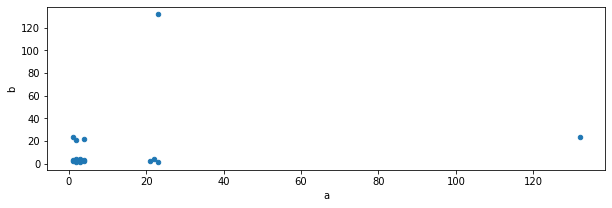

In [4]:
_ = df.plot.scatter(x="a", y="b", figsize=(10,3))

# Getting Started

## Import and Data

* Loading some plotting libraries
* Loading panel and activating it with [vega](https://vega.github.io/vega/) as plotting backend
* Load Covid data from [our world in data](https://covid.ourworldindata.org)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import panel as pn

pn.extension("vega")

In [ ]:
#!wget https://covid.ourworldindata.org/data/owid-covid-data.csv -O ../data/owid-covid-data.csv 
raw_data = pd.read_csv("../data/owid-covid-data.csv")

countries = raw_data.dropna(subset=["continent"])
countries["date"] = pd.to_datetime(countries.date)
countries_actual = countries.query(f"date == '{countries.date.max()}'")
print(f"defined \"countries_actual\" based on date {countries.date.max().date()}")

## From a figure to a Dashboard

* Visualize total covid cases over time
* Use `pn.interactive` to transform any python function into a minimal dashboard

In [ ]:
df = countries.pivot("date","location", "total_cases")
df[["Germany","France"]].plot.line(figsize=(16, 4))

In [ ]:
def create_plot(location = "Germany"):
    df = countries.pivot("date","location", "total_cases")
    fig = df[[location]].plot.line(title=f"total cases for {location}", figsize=(16, 4))
    return fig

In [ ]:
create_plot("France")

In [ ]:
def create_custom_attr_plot(location = "Germany", metric="total_cases_per_million"):
    df = countries.pivot("date","location", metric).loc[:, location]
    fig = df.plot.line(figsize=(16, 4), title=f"{metric} for {location}").get_figure()
    plt.close()
    return fig

european_countries = countries.query("continent == 'Europe'").location.drop_duplicates().to_list()
metrics = countries.filter(like="per_million").columns.to_list()

In [ ]:
pn.interact(create_custom_attr_plot, location=european_countries, metric=metrics)

## Creating Dashboards using the Parameterized class

* [Param](https://param.holoviz.org/) is powerful python library to create user-modifiable parameters to control code execution
* Using `param.Parameterized` the executables can be bound to parameters
* `pn.widgets` offer addition input elements such as multi-select

In [ ]:
import param
class PlotTimeline(param.Parameterized):
    def __init__(self, locations, metrics, default_location = "Germany", default_metric = "new_cases_per_million", **params):
        super(PlotTimeline, self).__init__(**params)
        self.location = pn.widgets.MultiChoice(name='Countries', value=[default_location], options=locations)
        self.target_col = pn.widgets.Select(name='Cols', value=default_metric,  options=metrics)

    def config(self):
        return pn.Column(self.location, self.target_col)
    
    @pn.depends('location.value', 'target_col.value')
    def view(self, *events, **kwargs):
        df = countries.pivot("date","location", self.target_col.value).loc[:, self.location.value]
        fig = df.plot.line(figsize=(16, 4), title=f"{self.target_col.value} for {self.location.value}").get_figure()
        plt.close()
        return fig

In [ ]:
country_names = countries.location.drop_duplicates().to_list()
metrics = countries.filter(like="per_million").columns.to_list()

timeline = PlotTimeline(country_names, metrics)

In [ ]:
pn.Row(timeline.config, timeline.view)

# Using Altair for dashboards

* [Altair](https://altair-viz.github.io/) is a declarative, descriptive visualization library for python
* Implements the [*grammer of graphics*](https://link.springer.com/book/10.1007/0-387-28695-0) paradigm based on [vega](https://vega.github.io/vega/) and [vega-lite](https://vega.github.io/vega-lite/)

In [ ]:
cols = ["total_cases_per_million","total_deaths_per_million", "people_vaccinated_per_hundred","life_expectancy", "human_development_index"]
df_long_form = countries_actual.loc[countries_actual.location.isin(["Germany","Argentina","France"]),["continent","location"]+cols].melt(["continent","location"])   

In [ ]:
import altair as alt
fig = alt.Chart(df_long_form, width=120, height=200).mark_point().encode(
    y="value", 
    shape="continent", 
    column="variable", 
    color="location", 
    x="continent", 
    tooltip=["location", "continent"]
).resolve_scale(y="independent")
fig

In [ ]:
import plotly.express as px
import param
class Plot(param.Parameterized):
    def __init__(self, locations, default_location = ["Germany","Argentina","France"], **params):
        super(Plot, self).__init__(**params)
        self.location = pn.widgets.MultiChoice(name='Countries', options=locations)

    def config(self):
        return pn.Column(self.location)
    
    @pn.depends('location.value')
    def view(self, *events, **kwargs):
        cols = ["total_cases_per_million","total_deaths_per_million", "people_vaccinated_per_hundred","life_expectancy", "human_development_index"]
        df = countries_actual.loc[countries_actual.location.isin(self.location.value),["continent","location"]+cols].melt(["continent","location"])
        fig = alt.Chart(df, width=120, height=200).mark_point().encode(
            y="value", shape="continent", column="variable", color="location", x="continent",  tooltip=["location", "continent"]
        ).resolve_scale(y="independent")
        return fig

country_names = countries.location.drop_duplicates().to_list()

multiple_1d_scatter = Plot(country_names)

pn.Row(multiple_1d_scatter.config, multiple_1d_scatter.view, max_height=400)

# Graphical data selection using Bokeh

* [Bokeh](https://bokeh.org/) is an open-source interactive python plotting library
* It bridges JavaScript and Python, thereby frontend events can effect python code
* This enables chart-selections events can change python variables
* Furthermore Bokeh also offers data tables

In [ ]:
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.plotting import figure
from bokeh.events import SelectionGeometry, Reset

In [ ]:
# Get Data
table_columns = ["continent", "location"] + countries_actual.filter(like="new").columns.to_list() + countries_actual.filter(like="total").columns.to_list()
table_data = countries_actual[table_columns].query("total_cases > 10").fillna(0)

# Create a Scatter Chart
selector = ColumnDataSource(data=table_data.to_dict(orient="list"))
scatter = figure(plot_width=400, plot_height=400, tools="lasso_select,box_zoom,pan,zoom_in,zoom_out,reset", active_drag="lasso_select", title="Select a Country")
scatter.circle('total_cases', 'total_deaths', source=selector)
pn.Row(scatter)

In [ ]:
# Create DataTable
column_data = ColumnDataSource(data=table_data.sample(0).to_dict(orient="list"))
table = DataTable(
    columns=[TableColumn(field=x, title=x) for x in table_data.columns],
    source=column_data, 
    max_width = 1500,
    height = 100,
    sizing_mode = "scale_width",
    autosize_mode="fit_viewport",
)

In [ ]:
# Create the filter-functionality Scatter -> Table
js_mappings = {
            "table_data": column_data,
            "data_source": eval(table_data.to_json(orient="records"))
        }
selector.selected.js_on_change('indices', CustomJS(args=js_mappings, code="""
        var inds = cb_obj.indices;
        var table = table_data.data;

        Object.keys(table).forEach(function(key){
            console.log(key)
            table[key] = []
            for (var i = 0; i < inds.length; i++) {
                table[key].push(data_source[inds[i]][key])
            }
        })
        table_data.change.emit();
    """))

In [ ]:
pn.Row(scatter, table)

# Combining everything a full dashboard

* Using panel different visualization libraries can be combined
* `on_change` binds a javascript **property** to a python function execution 
* `on_event` binds a javascript **event-trigger** to a python function execution

## Table Selection event

In [ ]:
column_data_full = ColumnDataSource(data=table_data.to_dict(orient="list"))

def select_user(attr, old, new):
    ids = [x for pos, x in enumerate(selector.selected.indices) if pos in new]
    locations = table_data.iloc[ids]["location"].to_list()
    timeline.location.value = locations


tab = DataTable(
    columns=[TableColumn(field=x, title=x) for x in table_data.columns],
    source=column_data_full, 
    max_width = 1500,
    height = 100,
    sizing_mode = "scale_width",
    autosize_mode="fit_viewport",
)    
column_data_full.selected.on_change("indices", select_user)
pn.Column(tab, timeline.view)

## Lasso Selection

In [ ]:
# Create the filter-functionality Scatter -> Panel Group Dashboard
def select_group(event):
    if event.final is True:
        ids = [x for pos, x in enumerate(selector.selected.indices)]
        locations = table_data.iloc[ids]["location"].to_list()
        multiple_1d_scatter.location.value = locations

scatter.on_event(SelectionGeometry, select_group)
scatter.on_event(Reset, select_group)

In [ ]:
pn.Row(scatter, multiple_1d_scatter.view)

## Creating the final structure: The 3-layer approach

    1. Layer: High-Level overview of all data points with limited information (Scatter Chart)
    2. Layer: visualizations and table to show a group of points and gain understanding (1D-scatter chart + data table)
    3. Layer: Detailed visualizations on single data points

In [ ]:
# Create the filter-functionality Scatter -> Panel Group Dashboard
def select_group(event):
    if event.final is True:
        ids = [x for pos, x in enumerate(selector.selected.indices)]
        locations = table_data.iloc[ids]["location"].to_list()
        multiple_1d_scatter.location.value = locations

scatter.on_event(SelectionGeometry, select_group)
scatter.on_event(Reset, select_group)

# Create the filter-functionality Table -> Layer 3 detailed timeline
def select_user(attr, old, new):
    ids = [x for pos, x in enumerate(selector.selected.indices) if pos in new]
    locations = table_data.iloc[ids]["location"].to_list()
    timeline.location.value = locations

column_data.selected.on_change("indices", select_user)
pn.Column(table, timeline )

# Show the whole Dashboard
dashboard = pn.Column(
    pn.Row(scatter, multiple_1d_scatter.view), 
    table, 
    pn.Row(timeline.config, timeline.view),
    title="Covid Dashboard"
)

In [ ]:
dashboard

In [ ]:
pn.serve(dashboard)

In [ ]:
%run _prepare.ipynb